In [2]:

import torch
import numpy as np
%load_ext autoreload
%autoreload 2
from utils import load_data,default_loader,trainset,imshow,normal,layershow
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torchsummary import summary
import datetime
import time,datetime
from scipy.integrate import solve_ivp
from bokeh.io import  output_notebook, push_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.models import Label
from ipywidgets import interact, FloatSlider
from bokeh.palettes import Category10, Category20
output_notebook(hide_banner=True)

**Data Path**

In [3]:
datapath = "/home/tete/data/Youtube"
data,paths,labels = load_data(datapath)
available_field = ['url','videoname','locs','frameids','label_names','crop','scale','origRes','isYouTubeSubset']


**shift the data**

In [4]:
num_data=len(paths)
index=np.arange(num_data)
np.random.shuffle(index)
paths=[paths[i] for i in index]
labels=[labels[i] for i in index]

**partition of the data into three part**

In [5]:
#how many data we will put into each set
train_num,val_num, test_num  = int(0.8*num_data),int(num_data*0.1),int(num_data*0.1)

bs=8

assert(train_num+val_num+test_num<=num_data)
train_path,train_label=paths[0:train_num],labels[0:train_num]
val_path,  val_label  =paths[train_num:train_num+val_num],labels[train_num:train_num+val_num]
test_path, test_label =paths[train_num+val_num:],labels[train_num+val_num:]

train_data  = trainset(train_path,train_label)
trainloader = DataLoader(train_data, batch_size=bs,shuffle=True)

val_data  = trainset(val_path,val_label)
valloader = DataLoader(val_data, batch_size=bs,shuffle=True)

test_data  = trainset(test_path,test_label)
testloader = DataLoader(test_data, batch_size=bs,shuffle=False)
print("number of data in the training set    :", len(train_data))
print("number of data in the validation set  :", len(val_data))
print("number of data in the test set        :", len(test_data))

number of data in the training set    : 4000
number of data in the validation set  : 500
number of data in the test set        : 500


**load example data from test set**

In [6]:
label1=test_data[0][1]
label2=test_data[1][1]
new_w,new_h=256,256


'''input two heatmap:
size: 7*256*256
'''
def distance_max(P,Q):
    c,w,h=P.shape
    distance=[]
    
    Pp=torch.argmax(P.reshape(c,w*h),dim=1)
    Qp=torch.argmax(Q.reshape(c,w*h),dim=1)
    Pw,Ph=Pp/256,Pp%256
    Qw,Qh=Qp/256,Qp%256
    
    Pp=np.array([Pw.cpu().numpy(),Ph.cpu().numpy()])
    Qp=np.array([Qw.cpu().numpy(),Qh.cpu().numpy()])
    tmp=Pp-Qp
    tmp=np.sum(tmp**2,axis=0)
    
    return np.sqrt(tmp)

def batch_distance(Qb,Pb):
    dis=[]
    for i in range(Qb.shape[0]):
        dis.append(distance_max(Qb[i],Pb[i]))
    return np.array(dis)

In [7]:
label1=torch.zeros([7,256,256])
label2=torch.zeros([7,256,256])
label1[0,1,1]=1
label2[0,2,2]=1
distance_max(label1,label2)

array([1.41421356, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [8]:
count = 1
for data in testloader:
    if count == 1:
        inputs_try,labels_try = data
    count +=1
print(count,"batches")   
print(inputs_try.shape)

64 batches
torch.Size([8, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


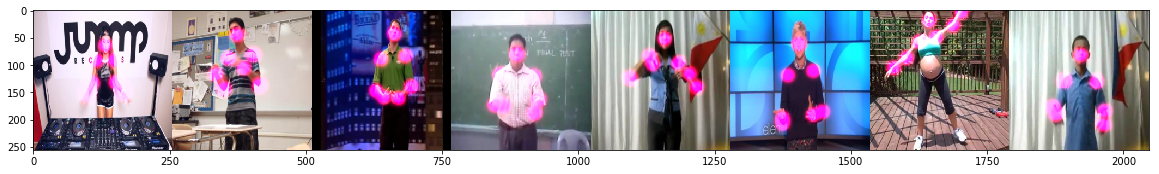

In [9]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,labels_try) 

In [10]:
use_gpu=torch.cuda.is_available()
use_gpu

True

In [16]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),  
            
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256,128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Upsample(size=(45,80),mode='bilinear'),
            
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Upsample(size=(90,160) ,mode='bilinear'), 
            
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Upsample(size=(256,256) ,mode='bilinear'), 
            
            
        )
        self.conv1=nn.Conv2d(128,128,3,stride=1,padding=1)
        self.conv2=nn.Conv2d(128,7,3,stride=1,padding=1)
        self.soft =nn.Softmax2d()
        
    def forward(self, x):
        x = self.encoder(x)
        x =self.decoder(x)
        x =self.conv1(x)
        x =nn.ReLU()(x)
        x =self.conv2(x)
#         x = x.view([-1,7,256*256])
#         x = nn.Softmax(dim=2)(x)
#         x = x.view([-1,7,256,256])
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = ConvolutionalAutoEncoder().to(device)
summary(model, (3, 256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
              ReLU-2         [-1, 16, 256, 256]               0
       BatchNorm2d-3         [-1, 16, 256, 256]              32
            Conv2d-4         [-1, 32, 256, 256]           4,640
              ReLU-5         [-1, 32, 256, 256]               0
       BatchNorm2d-6         [-1, 32, 256, 256]              64
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
              ReLU-9         [-1, 64, 128, 128]               0
      BatchNorm2d-10         [-1, 64, 128, 128]             128
           Conv2d-11        [-1, 128, 128, 128]          73,856
             ReLU-12        [-1, 128, 128, 128]               0
      BatchNorm2d-13        [-1, 128, 128, 128]             256
        MaxPool2d-14          [-1, 128,

In [17]:
plot_distance = 125
labels = ['Head', 'Right wrist', 'Left wrist', 'Right elbow', 'Left elbow', 'Right shoulder', 'Left shoulder']
def print_figure(distance):
    fig_sol = figure(x_range=(0, plot_distance), width=650, height=300, title="Solution")
    for i in range(7):
        d = distance[:,i]
        length_d = len(d)
        np.append(d,[plot_distance])
        counter = 0
        acc = []
        for j in range(plot_distance):
            while(counter<length_d and d[counter]<j):
                counter = counter+1
            acc.append(1.0*counter/length_d)
        fig_sol.line(range(plot_distance),acc,legend=labels[i],line_width=2,color=Category10[10][i])
    fig_sol.legend.location = "bottom_right"
    show(fig_sol)
            

In [18]:
def train(model,trainloader,loss_fn,optimizer):
    if use_gpu:
        model=model.to("cuda")
        
    model.train(True)
    optimizer = optimizer

    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    for data in trainloader:
        inputs, labels = data
        bs = labels.size(0)

        if use_gpu:
            inputs=inputs.cuda()
            labels=labels.cuda()


        outputs = model(inputs)
        #print(outputs.shape, labels.shape)
        loss = loss_fn(outputs,labels) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds=outputs.data
        # statistics
        running_loss += loss.data.item()
        if(size%int(len(trainloader)/5)==0 and size!=0):
            print(running_loss / size, size)
        size += bs
        
        
        size += bs
              
            
    epoch_loss = running_loss / size      
    return epoch_loss

def test(model,data_loader,loss_fn,optimizer):
    model.eval()
    if use_gpu:
        model=model.to("cuda")
    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    distance = []
    with torch.no_grad():

        for data in data_loader:
            inputs, labels = data    
            
            bs = labels.size(0)

            if use_gpu:
                inputs=inputs.cuda()
                labels=labels.cuda()

            outputs = model(inputs)
            loss = loss_fn(outputs,labels) 
            
            distance.extend(batch_distance(outputs,labels))
            
            
            running_loss += loss.data.item()
            #running_corrects += torch.sum(preds == labels)
            size += bs
        
        
        out = torchvision.utils.make_grid(inputs_try.cpu(),padding=0)
        preds=model(inputs_try.cuda()).cpu()
        imshow(out,preds.cpu())

        epoch_loss = running_loss / size
        
    distance = np.array(distance)
    distance.sort(axis=0)
    print_figure(distance)
    return epoch_loss

In [19]:
pose_detection = ConvolutionalAutoEncoder()
# choose the appropriate loss
loss_fn = nn.MSELoss(reduction='sum')
#loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1e-2
# your SGD optimizer
#optimizer_cl = torch.optim.Adadelta(pose_detection.parameters(),lr = learning_rate)
optimizer = torch.optim.Adam(pose_detection.parameters(),lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# and train for 10 epochs
l_t,l_v=[],[]

In [ ]:
num_epoch=10

time_begin=time.time()

for epoch in range(num_epoch):
    scheduler.step()
    epoch_loss=train(pose_detection,trainloader,loss_fn,optimizer)
    val_loss  =test(pose_detection,valloader,loss_fn,optimizer)
    print('Epoch:',epoch+1, ' Train - Loss: {:.2f} ; Validation - Loss: {:.2f}'.format(epoch_loss,val_loss))
    l_t.append(epoch_loss)
    l_v.append(val_loss)
    now=time.time()
    time_used=now-time_begin
    time_remain= time_used /(epoch+1) *(num_epoch-1-epoch)
    print("Time consumed:", datetime.timedelta(seconds=time_used), "Remaining time:", datetime.timedelta(seconds=time_remain))

385286.7301953125 400
195519.66534667969 800


464.6780151367187 400
455.5801605224609 800
452.5914229329427 1200
451.0640594482422 1600
450.1960539550781 2000
449.60117390950523 2400
449.1207493373326 2800
448.7739016723633 3200
448.48793334960936 3600
448.2890435791016 4000
448.1102772105824 4400
447.98122467041014 4800
447.868151949369 5200
447.7648809814453 5600
447.6478299153646 6000
447.55285987854006 6400
447.45846586339616 6800
447.37991007486977 7200
447.3222121710526 7600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


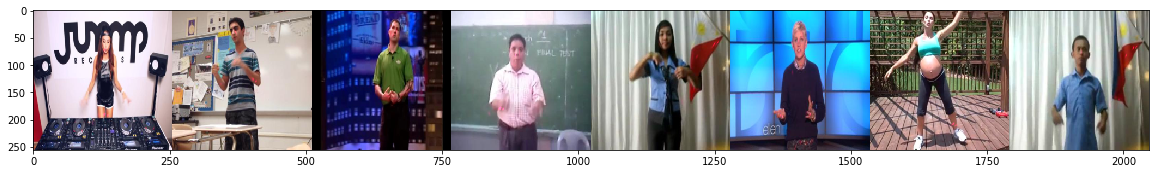

Epoch: 1  Train - Loss: 446.36 ; Validation - Loss: 892.02
Time consumed: 0:04:11.216594 Remaining time: 0:37:40.949344
463.95648315429685 400
455.1332244873047 800
452.19204060872397 1200
450.69542724609374 1600
449.8475983886719 2000
449.29156311035155 2400
448.88708862304685 2800
448.52305877685546 3200
448.2403865559896 3600
448.05730822753907 4000
447.8790615012429 4400
447.7401690673828 4800
447.5795283390926 5200
447.465736781529 5600
447.3813727213542 6000
447.2916714477539 6400
447.226795797909 6800
447.1587649875217 7200
447.10274465460526 7600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


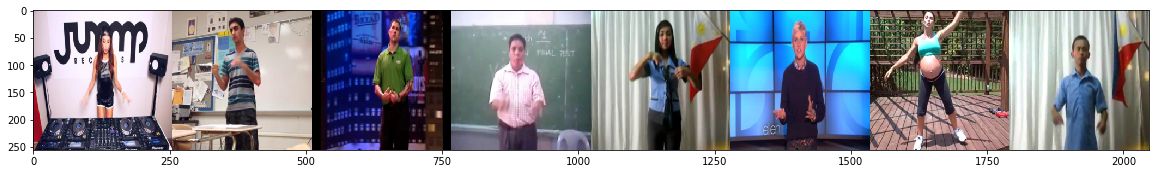

Epoch: 2  Train - Loss: 446.14 ; Validation - Loss: 891.63
Time consumed: 0:08:23.069690 Remaining time: 0:33:32.278759
463.51481079101563 400
454.84120849609377 800
451.8418428548177 1200
450.3782174682617 1600
449.49187280273435 2000
448.8986706542969 2400
448.42335414341517 2800
448.1037998962402 3200
447.8135477701823 3600
447.5850531005859 4000
447.4028376908736 4400
447.2583984375 4800
447.14477473332335 5200
447.0287761579241 5600
446.8942707519531 6000
446.8303601837158 6400
446.80962524414065 6800
446.8021201578776 7200
446.7872608706826 7600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


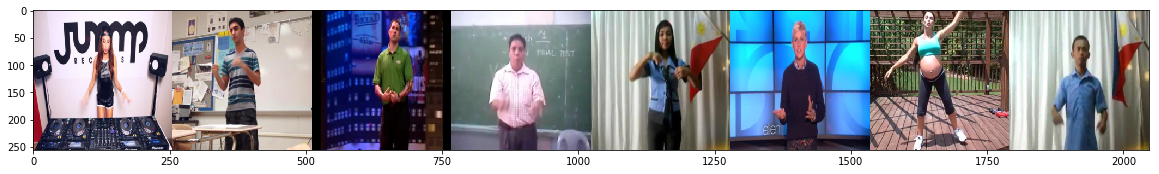

Epoch: 3  Train - Loss: 445.88 ; Validation - Loss: 892.93
Time consumed: 0:12:34.292256 Remaining time: 0:29:20.015264
464.46273315429687 400
455.33265502929686 800
452.3285974121094 1200
450.83785369873044 1600
449.977873046875 2000
449.3984649658203 2400
448.9489358956473 2800
448.54472869873047 3200
448.30882853190104 3600
448.10813903808594 4000
447.9509287331321 4400
447.81561767578125 4800
447.6950245079627 5200
447.5838293457031 5600
447.47583439127607 6000
447.3913387298584 6400
447.32113274069394 6800
447.2579741753472 7200
447.1744398900082 7600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


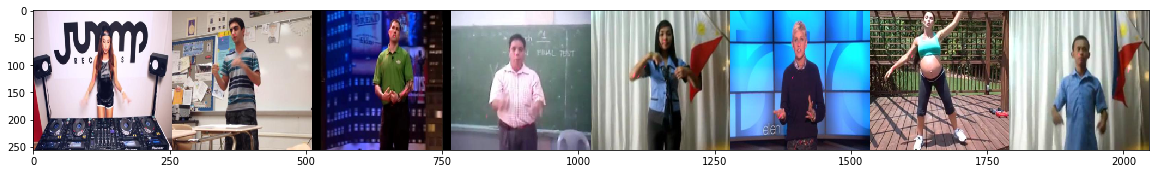

Epoch: 4  Train - Loss: 446.21 ; Validation - Loss: 891.48
Time consumed: 0:16:44.868319 Remaining time: 0:25:07.302479
463.8159020996094 400
454.68908142089845 800


KeyboardInterrupt: 

In [15]:
num_epoch=10

time_begin=time.time()

for epoch in range(num_epoch):
    scheduler.step()
    epoch_loss=train(pose_detection,trainloader,loss_fn,optimizer)
    val_loss  =test(pose_detection,valloader,loss_fn,optimizer)
    print('Epoch:',epoch+1, ' Train - Loss: {:.2f} ; Validation - Loss: {:.2f}'.format(epoch_loss,val_loss))
    l_t.append(epoch_loss)
    l_v.append(val_loss)
    now=time.time()
    time_used=now-time_begin
    time_remain= time_used /(epoch+1) *(num_epoch-1-epoch)
    print("Time consumed:", datetime.timedelta(seconds=time_used), "Remaining time:", datetime.timedelta(seconds=time_remain))

In [ ]:
plt.plot(range(len(l_t)),l_t,l_v)

In [ ]:
preds.shape ,labels_try.shape

In [ ]:
with torch.no_grad():
    preds=pose_detection(inputs_try.cuda()).cpu()
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,preds) 
imshow(out,labels_try) 